In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl 
from typing import Pattern, List
import os 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from src import  utils, precip, nino34, models, cesm_utils, cmip_utils, plots
from src.inputs import *
from concurrent.futures import ProcessPoolExecutor


%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
# List of CESM2 Ensemble Members
ensemble_members = models.CESM2_ensemble_members # List of CESM2 Ensemble Members

In [3]:
# Load observation data
prect_sources = ["GPCC", "CRUT", "APHR"]
sst_sources = ["ERSST", "HADISST", "COBESST"]

obs_msea_prect_anomalies = {source: utils.get_obs_msea_prect_anomaly_timeseries_mam(
    source, detrend_option=True) for source in prect_sources}
obs_nino34_sst_anomalies = {source: utils.get_obs_nino34_sst_anomaly_timeseries_djf(
    source, detrend_option=True) for source in sst_sources}

obs_msea_prect_climatologies = {source: utils.get_obs_msea_prect_climatology_timeseries_mam(
    source, detrend_option=True) for source in prect_sources}

In [4]:
# Load CESM data
cesm_nino34_djf_sst_timeseries = cesm_utils.process_cesm_ensemble(
    ensemble_members, 
    CESM2_LENS2_dir,
    "SST.Nino34")  # annual global DJF ssts
cesm_msea_mam_prect_timeseries = cesm_utils.process_cesm_ensemble(
    ensemble_members,
    CESM2_LENS2_dir,
    "PRECT.MSEA")  # monthly MSEA ssts
cesm_msea_mam_prect_timeseries_clm = cesm_utils.process_cesm_ensemble(
    ensemble_members,
    CESM2_LENS2_dir,
    "PRECT.MSEA",
    anomaly=False)  # monthly MSEA ssts

In [5]:
# List of CMIP6 models used in this study
cmip6_models = models.CMIP6_models
sorted_models = sorted(cmip6_models)

In [6]:
# Open CMIP6 data and regrid to common 1x1 gr grid.
# For each CMIP6 model, calculate MAM prect in msea region (precip_anm)
# and calculate corresponding DJF sst in Niño3.4 region (nino34_djf_ersst)

# note: this cell should take <3m to run

anomaly=True
with ProcessPoolExecutor() as executor:
    results = list(executor.map(cmip_utils.process_cmip_ensemble, sorted_models, [anomaly]*len(sorted_models)))

cmip6_tos_anms, cmip6_precip_anms = zip(*results)

anomaly=False
with ProcessPoolExecutor() as executor:
    results = list(executor.map(cmip_utils.process_cmip_ensemble, sorted_models, [anomaly]*len(sorted_models)))

_, cmip6_precip_clms = zip(*results)

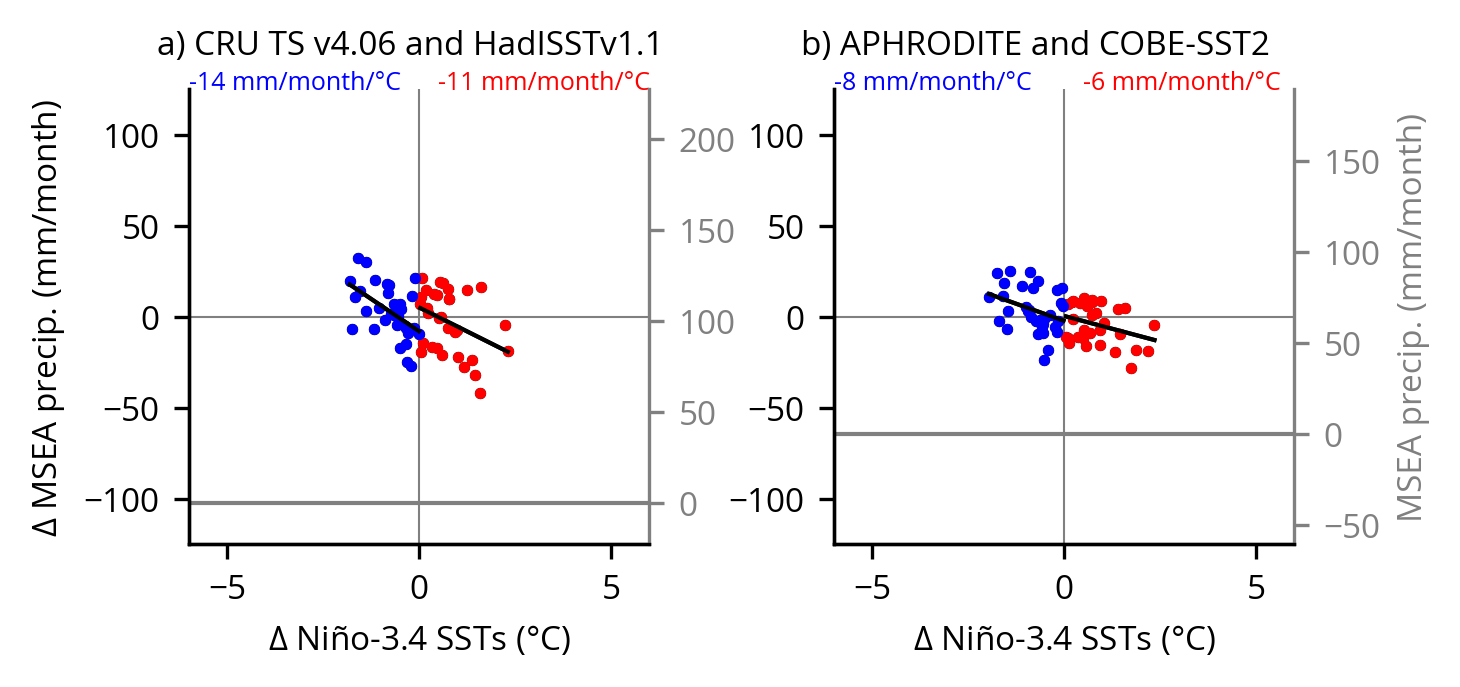

In [7]:
utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 12
fig_height_cm = 5.5

fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 2, top=0.90, bottom=0.2, left=0.12, right=0.90, hspace=0.6, wspace=0.4)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])

############## Figure 4a ##############
precip_anms = [obs_msea_prect_anomalies["CRUT"]]
precip_clms = [obs_msea_prect_climatologies["CRUT"]]
sst_anm_nino34s = [obs_nino34_sst_anomalies["HADISST"]]

for precip_anm, precip_clm, sst_anm_nino34 in zip(precip_anms, precip_clms, sst_anm_nino34s):
    # Process anomalies and filter events
    sst_shifted = plots.select_and_shift_sst(sst_anm_nino34, start='1951', end='2015')
    elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anm.sel(time=slice('1951', '2015')), sst_shifted)
    elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clm.sel(time=slice('1951', '2015')), sst_shifted)

    # save these values to adjust the y-axis limits below  
    a = elnino_pre
    b = elnino_pre_clm

    # Plotting and annotations for Figure 4a
    ax1_right = ax1.twinx()
    ax1_right.spines['right'].set_color('gray')
    ax1_right.tick_params(axis='y', colors='gray')

    plots.plot_enso_asymmetry_scatter(ax1_right, elnino_sst_clm, elnino_pre_clm, lanina_sst_clm, lanina_pre_clm, el_color='red', la_color='blue')
    ax1_right.set_ylim(-125+np.mean(b-a), 125+np.mean(b-a))
    plots.plot_enso_asymmetry_scatter(ax1, elnino_sst, elnino_pre, lanina_sst, lanina_pre, el_color='black', la_color='black')
    plots.annotate_slope(ax1, elnino_sst, elnino_pre, x_pos=0.5, label_color='red')
    plots.annotate_slope(ax1, lanina_sst, lanina_pre, x_pos=-6, label_color='blue')
    plots.annotate_slope(ax1_right, elnino_sst_clm, elnino_pre_clm, x_pos=0.5, label_color='red', label=False)
    plots.annotate_slope(ax1_right, lanina_sst_clm, lanina_pre_clm, x_pos=-6, label_color='blue', label=False)
    ax1.axhline(-np.nanmean(b-a), color="grey", linewidth=1)

############## Figure 4b ##############
precip_anms = [obs_msea_prect_anomalies["APHR"]]
precip_clms = [obs_msea_prect_climatologies["APHR"]]
sst_anm_nino34s = [obs_nino34_sst_anomalies["COBESST"]]

for precip_anm, precip_clm, sst_anm_nino34 in zip(precip_anms, precip_clms, sst_anm_nino34s):
    # Process anomalies and filter events
    sst_shifted = plots.select_and_shift_sst(sst_anm_nino34, time_shift=1, start='1951', end='2015')
    elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anm.sel(time=slice('1951', '2015')), sst_shifted)
    elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clm.sel(time=slice('1951', '2015')), sst_shifted)

    # save these values to adjust the y-axis limits below  
    a = elnino_pre
    b = elnino_pre_clm

    # Plotting and annotations for Figure 4b
    ax2_right = ax2.twinx()
    ax2_right.spines['right'].set_color('gray')
    ax2_right.tick_params(axis='y', colors='gray')
    ax2.axhline(-np.nanmean(b-a), color="grey", linewidth=1)

    plots.plot_enso_asymmetry_scatter(ax2_right, elnino_sst_clm, elnino_pre_clm, lanina_sst_clm, lanina_pre_clm)
    ax2_right.set_ylim(-125+np.mean(b-a), 125+np.mean(b-a))
    plots.plot_enso_asymmetry_scatter(ax2, elnino_sst, elnino_pre, lanina_sst, lanina_pre, el_color='black', la_color='black')
    plots.annotate_slope(ax2, elnino_sst, elnino_pre, x_pos=0.5, label_color='red')
    plots.annotate_slope(ax2, lanina_sst, lanina_pre, x_pos=-6, label_color='blue')
    plots.annotate_slope(ax2_right, elnino_sst_clm, elnino_pre_clm, x_pos=0.5, label_color='red', label=False)
    plots.annotate_slope(ax2_right, lanina_sst_clm, lanina_pre_clm, x_pos=-6, label_color='blue', label=False)

##############################################

for ax in [ax1, ax2]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

ax1_right.spines['top'].set_visible(False)
ax2_right.spines['top'].set_visible(False)

ax1.set_ylabel("$\Delta$ MSEA precip. (mm/month)")
ax2_right.set_ylabel("MSEA precip. (mm/month)", color="gray")

# Set axis limits for all subplots
for ax in [ax1, ax2]:
    ax.set_ylim(-125, 125)
    ax.set_xlim(-6, 6)  

# Set subplot labels
titles1 = ["a) CRU TS v4.06 and HadISSTv1.1", "b) APHRODITE and COBE-SST2"]
titles2 = [None, None]
colors = ['k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.06), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.06), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("FigS6.png")
plt.savefig("FigS6.pdf")

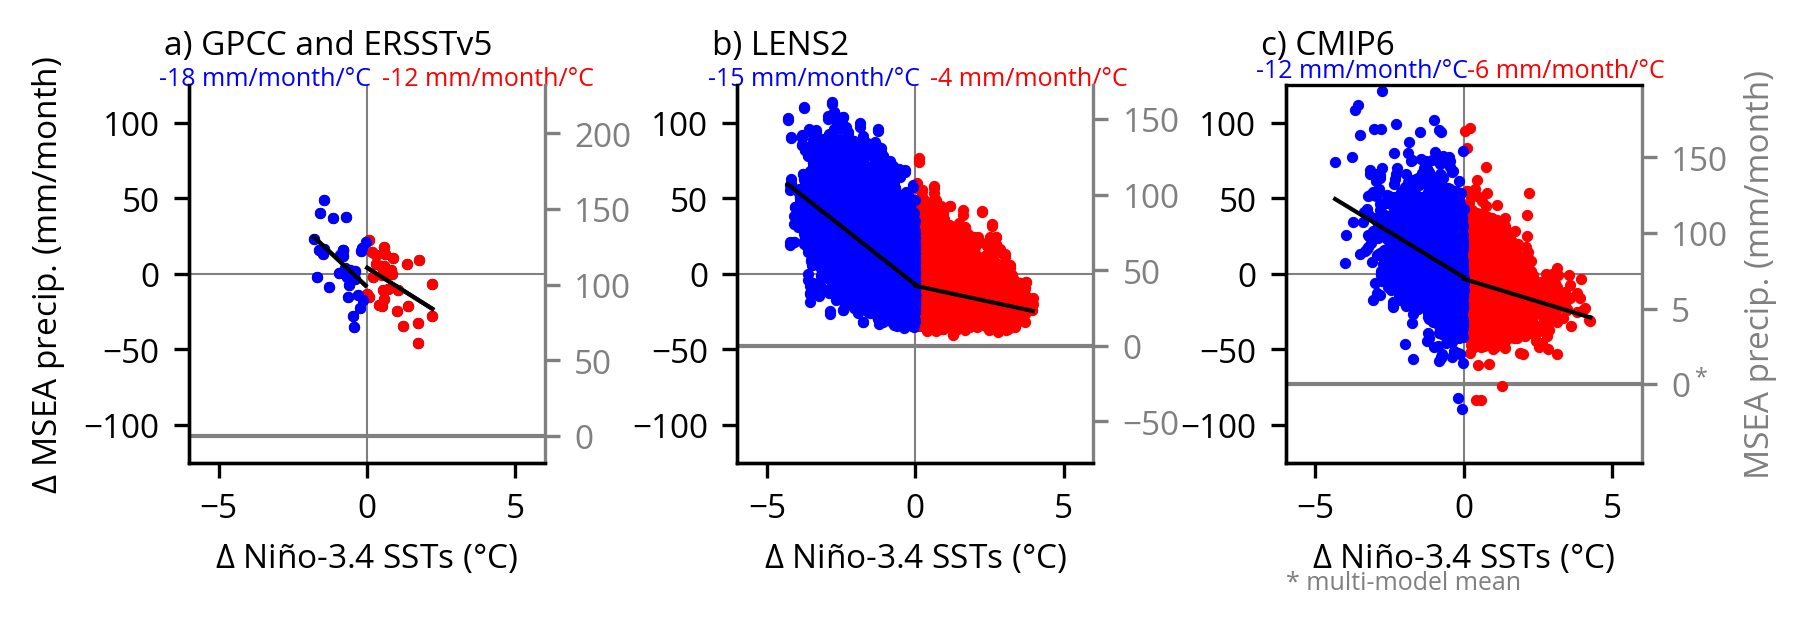

In [8]:
utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15
fig_height_cm = 5
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 3, top=0.89, bottom=0.25, left=0.10, right=0.92, hspace=0.2, wspace=0.54)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])

############## Figure 4a ##############
precip_anms = [obs_msea_prect_anomalies["GPCC"]]
precip_clms = [obs_msea_prect_climatologies["GPCC"]]
sst_anm_nino34s = [obs_nino34_sst_anomalies["ERSST"]]

for precip_anm, precip_clm, sst_anm_nino34 in zip(precip_anms, precip_clms, sst_anm_nino34s):
    # Process anomalies and filter events
    sst_shifted = plots.select_and_shift_sst(sst_anm_nino34, start='1951', end='2015')
    elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anm.sel(time=slice('1951', '2015')), sst_shifted)
    elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clm.sel(time=slice('1951', '2015')), sst_shifted)

    # save these values to adjust the y-axis limits below  
    a = elnino_pre
    b = elnino_pre_clm
    
    # Plotting and annotations for Figure 4a
    ax1_right = ax1.twinx()
    ax1_right.spines['right'].set_color('gray')
    ax1_right.tick_params(axis='y', colors='gray')

    plots.plot_enso_asymmetry_scatter(ax1_right, elnino_sst_clm, elnino_pre_clm, lanina_sst_clm, lanina_pre_clm)
    ax1.axhline(-np.nanmean(b-a), color="grey", linewidth=1)
    ax1_right.set_ylim(-125+np.mean(b-a), 125+np.mean(b-a))

    plots.plot_enso_asymmetry_scatter(ax1, elnino_sst, elnino_pre, lanina_sst, lanina_pre, el_color='black', la_color='black')
    plots.annotate_slope(ax1, elnino_sst, elnino_pre, x_pos=0.5, label_color='red')
    plots.annotate_slope(ax1, lanina_sst, lanina_pre, x_pos=-7, label_color='blue')
    plots.annotate_slope(ax1_right, elnino_sst_clm, elnino_pre_clm, x_pos=0.5, label_color='red', label=False)
    plots.annotate_slope(ax1_right, lanina_sst_clm, lanina_pre_clm, x_pos=-7, label_color='blue', label=False)

############## Figure 4b ##############
precip_anms = cesm_msea_mam_prect_timeseries
precip_clms = cesm_msea_mam_prect_timeseries_clm
sst_anm_nino34s = cesm_nino34_djf_sst_timeseries

# Process anomalies and filter events
sst_shifted = plots.select_and_shift_sst(sst_anm_nino34s, start='1900', end='2014')
elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anms.sel(time=slice('1900', '2014')), sst_shifted)
elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clms.sel(time=slice('1900', '2014')), sst_shifted)

# save these values to adjust the y-axis limits below  
a = elnino_pre
b = elnino_pre_clm

# Plotting and annotations for Figure 4a
ax2_right = ax2.twinx()
ax2_right.spines['right'].set_color('gray')
ax2_right.tick_params(axis='y', colors='gray')

plots.plot_enso_asymmetry_scatter(ax2_right, elnino_sst_clm, elnino_pre_clm, lanina_sst_clm, lanina_pre_clm)
ax2_right.set_ylim(-125+np.nanmean(b-a), 125+np.nanmean(b-a))
ax2.axhline(-np.nanmean(b-a), color="grey", linewidth=1)
plots.plot_enso_asymmetry_scatter(ax2, elnino_sst, elnino_pre, lanina_sst, lanina_pre, el_color='red', la_color='blue')
plots.annotate_slope(ax2, elnino_sst, elnino_pre, x_pos=0.5, label_color='red')
plots.annotate_slope(ax2, lanina_sst, lanina_pre, x_pos=-7, label_color='blue')
plots.annotate_slope(ax2_right, elnino_sst_clm, elnino_pre_clm, x_pos=0.5, label_color='red', label=False)
plots.annotate_slope(ax2_right, lanina_sst_clm, lanina_pre_clm, x_pos=-7, label_color='blue', label=False)


############## Figure 4c - Aggregated Slopes for Models in Criteria ##############
precip_anms = cmip6_precip_anms
precip_clms = cmip6_precip_clms
sst_anm_nino34s = cmip6_tos_anms

criteria = sorted_models  # Set the criteria for model selection

slope_elninos = []
slope_laninas = []

elnino_sst_all = []
elnino_sst_all_clm = []

elnino_pre_all = []
elnino_pre_all_clm = []

lanina_sst_all = []
lanina_sst_all_clm = []

lanina_pre_all = []
lanina_pre_all_clm = []


# Process each model in cmip6_precip_anms and cmip6_tos_anms that meets criteria
for precip_anm, precip_clm, sst_anm_nino34, sorted_model in zip(precip_anms, precip_clms, sst_anm_nino34s, sorted_models):
    if sorted_model in criteria:
        if sorted_model != "NESM3":
            #precip_anm['time'] = sst_anm_nino34.time
            #precip_clm['time'] = sst_anm_nino34.time
            sst_shifted = sst_anm_nino34.shift(time=1).sel(time=slice('1900', '2014'))
            elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anm, sst_shifted)
            elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clm, sst_shifted)

        elnino_sst_all.extend(elnino_sst)
        elnino_pre_all.extend(elnino_pre)
        lanina_sst_all.extend(lanina_sst)
        lanina_pre_all.extend(lanina_pre)

        elnino_sst_all_clm.extend(elnino_sst_clm)
        elnino_pre_all_clm.extend(elnino_pre_clm)
        lanina_sst_all_clm.extend(lanina_sst_clm)
        lanina_pre_all_clm.extend(lanina_pre_clm)

# Plot aggregated scatter points and calculate slopes for Figure 4c
plots.plot_enso_asymmetry_scatter(ax3, elnino_sst_all, elnino_pre_all, lanina_sst_all, lanina_pre_all)

a = elnino_pre_all
b = elnino_pre_all_clm

ax3.axhline(-np.nanmean(np.array(b)-np.array(a)), color="grey", linewidth=1)
ax3_right = ax3.twinx()
ax3_right.spines['right'].set_color('gray')
ax3_right.tick_params(axis='y', colors='gray')
ax3_right.set_ylim(-125, 125)
ax3_right.set_yticks([77, 27, -23, -np.nanmean(np.array(b)-np.array(a))])
ax3_right.set_yticklabels([150, 100, 5, "0$^*$"])


slope_elnino = plots.plot_linregress(elnino_sst_all, elnino_pre_all, ax=ax3, color='k', linewidth=1)
ax3.text(0.1, 130, f'{slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)
slope_lanina = plots.plot_linregress(lanina_sst_all, lanina_pre_all, ax=ax3, color='k', linewidth=1)
ax3.text(-7, 130, f'{slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)

##############################################

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

ax1.set_ylabel("$\Delta$ MSEA precip. (mm/month)")
ax3_right.set_ylabel("MSEA precip. (mm/month)", color="gray")

# Set axis limits for all subplots
for ax in [ax1, ax2, ax3]:
    ax.set_ylim(-125, 125)
    ax.set_xlim(-6, 6)  


ax1_right.spines['top'].set_visible(False)
ax2_right.spines['top'].set_visible(False)


# Set subplot labels
titles1 = ["a) GPCC and ERSSTv5", "b) LENS2", "c) CMIP6"]
titles2 = [None, None, None]
colors = ['k', 'k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.06), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.06), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

ax3.annotate("* multi-model mean", xy=(0, -0.35), xycoords='axes fraction', fontsize=6, color="grey", ha='left', va='bottom')
plt.savefig("Fig4.png")
plt.savefig("Fig4.pdf")

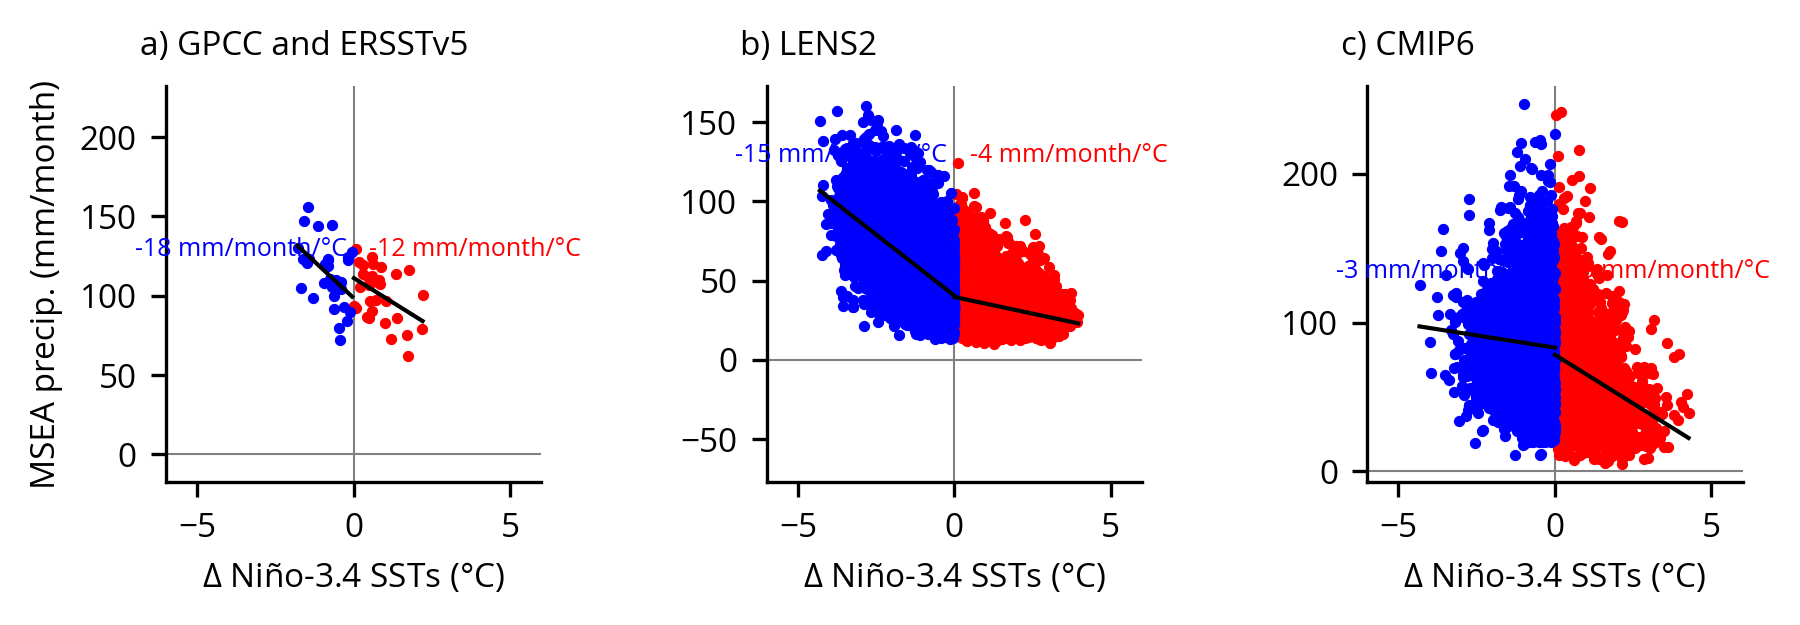

In [9]:
utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 15
fig_height_cm = 5
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 3, top=0.89, bottom=0.22, left=0.10, right=0.99, hspace=0.2, wspace=0.6)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])

############## Figure 4a ##############
precip_anms = [obs_msea_prect_anomalies["GPCC"]]
precip_clms = [obs_msea_prect_climatologies["GPCC"]]
sst_anm_nino34s = [obs_nino34_sst_anomalies["ERSST"]]

for precip_anm, precip_clm, sst_anm_nino34 in zip(precip_anms, precip_clms, sst_anm_nino34s):
    # Process anomalies and filter events
    sst_shifted = plots.select_and_shift_sst(sst_anm_nino34, start='1951', end='2015')
    elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anm.sel(time=slice('1951', '2015')), sst_shifted)
    elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clm.sel(time=slice('1951', '2015')), sst_shifted)

    # save these values to adjust the y-axis limits below  
    a = elnino_pre
    b = elnino_pre_clm

    plots.plot_enso_asymmetry_scatter(ax1, elnino_sst_clm, elnino_pre_clm, lanina_sst_clm, lanina_pre_clm)
    ax1.set_ylim(-125+np.nanmean(b-a), 125+np.nanmean(b-a))

    plots.annotate_slope(ax1, elnino_sst_clm, elnino_pre_clm, x_pos=0.5, label_color='red')
    plots.annotate_slope(ax1, lanina_sst_clm, lanina_pre_clm, x_pos=-7, label_color='blue')

############## Figure 4b ##############
precip_anms = cesm_msea_mam_prect_timeseries
precip_clms = cesm_msea_mam_prect_timeseries_clm
sst_anm_nino34s = cesm_nino34_djf_sst_timeseries

# Process anomalies and filter events
sst_shifted = plots.select_and_shift_sst(sst_anm_nino34s, start='1900', end='2014')
elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anms.sel(time=slice('1900', '2014')), sst_shifted)
elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clms.sel(time=slice('1900', '2014')), sst_shifted)

# save these values to adjust the y-axis limits below  
a = elnino_pre
b = elnino_pre_clm

plots.plot_enso_asymmetry_scatter(ax2, elnino_sst_clm, elnino_pre_clm, lanina_sst_clm, lanina_pre_clm)
ax2.set_ylim(-125+np.nanmean(b-a), 125+np.nanmean(b-a))
plots.annotate_slope(ax2, elnino_sst_clm, elnino_pre_clm, x_pos=0.5, label_color='red')
plots.annotate_slope(ax2, lanina_sst_clm, lanina_pre_clm, x_pos=-7, label_color='blue')

############## Figure 4c - Aggregated Slopes for Models in Criteria ##############
precip_anms = cmip6_precip_anms
precip_clms = cmip6_precip_clms
sst_anm_nino34s = cmip6_tos_anms

criteria = sorted_models  # Set the criteria for model selection

slope_elninos = []
slope_laninas = []

elnino_sst_all = []
elnino_sst_all_clm = []

elnino_pre_all = []
elnino_pre_all_clm = []

lanina_sst_all = []
lanina_sst_all_clm = []

lanina_pre_all = []
lanina_pre_all_clm = []


# Process each model in cmip6_precip_anms and cmip6_tos_anms that meets criteria
for precip_anm, precip_clm, sst_anm_nino34, sorted_model in zip(precip_anms, precip_clms, sst_anm_nino34s, sorted_models):
    if sorted_model in criteria:
        if sorted_model == "NESM3":
            precip_anm['time'] = sst_anm_nino34.time
            precip_clm['time'] = sst_anm_nino34.time
        sst_shifted = sst_anm_nino34.shift(time=1).sel(time=slice('1900', '2014'))
        elnino_sst, lanina_sst, elnino_pre, lanina_pre = plots.filter_enso_events(precip_anm, sst_shifted)
        elnino_sst_clm, lanina_sst_clm, elnino_pre_clm, lanina_pre_clm = plots.filter_enso_events(precip_clm, sst_shifted)

        elnino_sst_all.extend(elnino_sst)
        elnino_pre_all.extend(elnino_pre)
        lanina_sst_all.extend(lanina_sst)
        lanina_pre_all.extend(lanina_pre)

        elnino_sst_all_clm.extend(elnino_sst_clm)
        elnino_pre_all_clm.extend(elnino_pre_clm)
        lanina_sst_all_clm.extend(lanina_sst_clm)
        lanina_pre_all_clm.extend(lanina_pre_clm)

# Plot aggregated scatter points and calculate slopes for Figure 4c
plots.plot_enso_asymmetry_scatter(ax3, elnino_sst_all_clm, elnino_pre_all_clm, lanina_sst_all_clm, lanina_pre_all_clm)

slope_elnino = plots.plot_linregress(elnino_sst_all_clm, elnino_pre_all_clm, ax=ax3, color='k', linewidth=1)
ax3.text(0.1, 130, f'{slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)
slope_lanina = plots.plot_linregress(lanina_sst_all_clm, lanina_pre_all_clm, ax=ax3, color='k', linewidth=1)
ax3.text(-7, 130, f'{slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)

##############################################

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

ax1.set_ylabel("MSEA precip. (mm/month)")
ax2_right.set_ylabel("$\Delta$ MSEA precip. (mm/month)", color="gray")

# Set axis limits for all subplots
for ax in [ax1, ax2, ax3]:
    #ax.set_ylim(-125, 125)
    ax.set_xlim(-6, 6)  

# Set subplot labels
titles1 = ["a) GPCC and ERSSTv5", "b) LENS2", "c) CMIP6"]
titles2 = [None, None, None]
colors = ['k', 'k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.06), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.06), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

#plt.savefig("Fig4.png")
#plt.savefig("Fig4.pdf")